# Lab:  Logistic Regression for Gene Expression Data

In this lab, we use logistic regression to predict biological characteristics ("phenotypes") from gene expression data.  In addition to the concepts in the [breast cancer demo](./demo04_breast_cancer.ipynb), you will learn to:
* Handle missing data
* Perform multi-class logistic classification
* Create a confusion matrix
* Use L1-regularization for improved estimation in the case of sparse weights

## Background

Genes are the basic unit in the DNA and encode blueprints for proteins.  When proteins are synthesized from a gene, the gene is said to "express".  Micro-arrays are devices that measure the expression levels of large numbers of genes in parallel.  By finding correlations between expression levels and phenotypes, scientists can identify possible genetic markers for biological characteristics.

The data in this lab comes from:

https://archive.ics.uci.edu/ml/datasets/Mice+Protein+Expression

In this data, mice were characterized by three properties:
* Whether they had down's syndrome (trisomy) or not
* Whether they were stimulated to learn or not
* Whether they had a drug memantine or a saline control solution.

With these three choices, there are 8 possible classes for each mouse.  For each mouse, the expression levels were measured across 77 genes.  We will see if the characteristics can be predicted from the gene expression levels.  This classification could reveal which genes are potentially involved in Down's syndrome and if drugs and stimulation have any noticeable effects.


## Load the Data

We begin by loading the standard modules.

In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn import linear_model, preprocessing

Use the `pd.read_excel` command to read the data from 

https://archive.ics.uci.edu/ml/machine-learning-databases/00342/Data_Cortex_Nuclear.xls

into a dataframe `df`.  Use the `index_col` option to specify that column 0 is the index.  Use the `df.head()` to print the first few rows.

In [2]:
# TODO
# df = ...
df=pd.read_excel('https://archive.ics.uci.edu/ml/machine-learning-databases/00342/Data_Cortex_Nuclear.xls',index_col=0)
print(df.head())

         DYRK1A_N   ITSN1_N    BDNF_N     NR1_N    NR2A_N    pAKT_N   pBRAF_N  \
MouseID                                                                         
309_1    0.503644  0.747193  0.430175  2.816329  5.990152  0.218830  0.177565   
309_2    0.514617  0.689064  0.411770  2.789514  5.685038  0.211636  0.172817   
309_3    0.509183  0.730247  0.418309  2.687201  5.622059  0.209011  0.175722   
309_4    0.442107  0.617076  0.358626  2.466947  4.979503  0.222886  0.176463   
309_5    0.434940  0.617430  0.358802  2.365785  4.718679  0.213106  0.173627   

         pCAMKII_N   pCREB_N    pELK_N  ...   pCFOS_N     SYP_N  H3AcK18_N  \
MouseID                                 ...                                  
309_1     2.373744  0.232224  1.750936  ...  0.108336  0.427099   0.114783   
309_2     2.292150  0.226972  1.596377  ...  0.104315  0.441581   0.111974   
309_3     2.283337  0.230247  1.561316  ...  0.106219  0.435777   0.111883   
309_4     2.152301  0.207004  1.595086  ..

This data has missing values.  The site:

http://pandas.pydata.org/pandas-docs/stable/missing_data.html

has an excellent summary of methods to deal with missing values.  Following the techniques there, create a new data frame `df1` where the missing values in each column are filled with the mean values from the non-missing values.

In [3]:
# TODO
# df1 = ...
df1=df.fillna(df.mean())
print(df1.head(20))
print(df1)

         DYRK1A_N   ITSN1_N    BDNF_N     NR1_N    NR2A_N    pAKT_N   pBRAF_N  \
MouseID                                                                         
309_1    0.503644  0.747193  0.430175  2.816329  5.990152  0.218830  0.177565   
309_2    0.514617  0.689064  0.411770  2.789514  5.685038  0.211636  0.172817   
309_3    0.509183  0.730247  0.418309  2.687201  5.622059  0.209011  0.175722   
309_4    0.442107  0.617076  0.358626  2.466947  4.979503  0.222886  0.176463   
309_5    0.434940  0.617430  0.358802  2.365785  4.718679  0.213106  0.173627   
309_6    0.447506  0.628176  0.367388  2.385939  4.807635  0.218578  0.176233   
309_7    0.428033  0.573696  0.342709  2.334224  4.473130  0.225173  0.184004   
309_8    0.416923  0.564036  0.327703  2.260135  4.268735  0.214834  0.179668   
309_9    0.386311  0.538428  0.317720  2.125725  4.063950  0.207222  0.167778   
309_10   0.380827  0.499294  0.362462  2.096266  3.598587  0.227649  0.188093   
309_11   0.366511  0.513278 

## Binary Classification for Down's Syndrome

We will first predict the binary class label in `df1['Genotype']` which indicates if the mouse has Down's syndrome or not.  Get the string values in `df1['Genotype'].values` and convert this to a numeric vector `y` with 0 or 1.  You may wish to use the `np.unique` command with the `return_inverse=True` option.

In [4]:
# TODO
# y = ...
y=df1['Genotype'].values

y1=np.unique(y,return_inverse=True)

print(y1[1])


[0 0 0 ... 1 1 1]


As predictors, get all but the last four columns of the dataframes.  Standardize the data matrix and call the standardized matrix `Xs`.  The predictors are the expression levels of the 77 genes. 

In [5]:
# TODO
# Xs = ..
df2=df1.iloc[:,0:77]
from sklearn.preprocessing import StandardScaler
scaler=StandardScaler()
Xs=scaler.fit_transform(df2)


print(Xs)

[[ 0.31271112  0.5179336   2.2536689  ... -1.41662394 -1.60789061
   1.06590091]
 [ 0.35679793  0.28650133  1.8802795  ... -1.32521803 -1.54684392
   1.28029118]
 [ 0.33496588  0.45046461  2.01292763 ... -1.37325709 -1.62359464
   1.85703831]
 ...
 [-0.79192771 -0.88354273 -1.72382963 ...  1.27078193  3.11724261
   0.29352469]
 [-0.82188815 -0.8130138  -1.52387571 ...  1.88117889  3.32828966
   0.2089962 ]
 [-0.49491588 -0.62125474 -1.26845332 ...  1.92748438  3.32672533
   0.10478825]]


Create a `LogisticRegression` object `logreg` and `fit` the training data. Use `C = 1e5`and the 'liblinear' solver.

In [6]:
logreg=linear_model.LogisticRegression(C = 1e5,solver='liblinear')
logreg.fit(Xs,y)

LogisticRegression(C=100000.0, solver='liblinear')

Measure the training accuracy of the classifer.  That is, use the `logreg.predict` function to predict labels `yhat` and measure the fraction of cases that the predictions match the true labels.  Later, we will evaluate the accuracy (and AUC) more properly using cross-validation.

In [7]:
yhat = logreg.predict(Xs)
acc = np.mean(yhat == y)
print("Accuracy on training data = %f" % acc)

Accuracy on training data = 1.000000


## Interpreting the weight vector

Create a stem plot of the coefficients, `W`, in the logistic regression model using `plt.stem`.  You can get the coefficients from `logreg.coef_`, but you will need to reshape this to a 1D array.  

<StemContainer object of 3 artists>

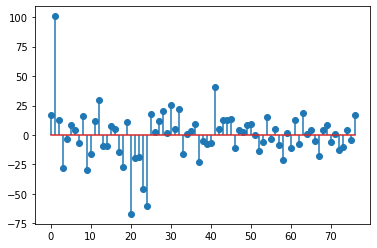

In [8]:
# TODO
W = logreg.coef_.reshape(-1)
plt.stem(W)

You should see that `W[i]` is very large for a few components `i`.  These are the genes that are likely to be most involved in Down's Syndrome.  Using L1 regularization we will later force logistic regression to return a sparse vector `W`.  

Find the names of the genes for two components `i` where the magnitude of `W[i]` is largest.  

In [9]:
# TODO
print(W)
index = np.argsort(-W)
print(index[0])
print(index[1])
print(df1.columns[index[0]])
print(df1.columns[index[1]])

[ 16.76135724 100.78769901  12.43390757 -28.41889476  -3.13661177
   8.31686459   4.48339598  -7.23332112  16.44125793 -29.52483617
 -16.10991204  11.65602682  29.69027298  -9.21647777  -9.69224115
   7.65403073   4.70974599 -14.43352567 -27.44049414  11.3944864
 -67.05273386 -19.22542662 -18.40367014 -45.69826893 -59.98744224
  17.8109068    2.09228142  11.87741955  20.10203784   1.27185231
  25.31128988   4.95261388  22.06829921 -16.01102568   0.68655865
   3.73202037   9.00451197 -23.37414069  -5.20686433  -7.65245573
  -6.53590684  41.01296015   4.79735591  12.91835668  13.10267379
  13.32555267 -10.75292377   4.18546144   2.24042038   8.56269001
   9.7144092    0.26439961 -13.92265794  -5.82087674  15.55343684
  -3.86288711   4.90784329  -8.94666162 -21.18951067   1.38576505
 -11.14203398  12.39700772  -7.57901984  18.22546039   0.8688318
   4.09998185  -4.9507163  -17.72662673   3.93749257   8.30648489
  -5.82087674   0.39376139 -13.16307908 -10.18088836   4.55877818
  -3.9270076

## Cross Validation

The above meaured the accuracy on the training data.  It is more accurate to measure the accuracy on the test data.  Perform 10-fold cross validation and measure the average precision, recall, and f1-score, and error rate.  Note that in performing the cross-validation, you will want to randomly permute the test and training sets using the `shuffle` option.  In this data set, all the samples from each class are bunched together, so shuffling is essential.  Print the mean precision, recall, f1-score, and error rate across all the folds.

In [10]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_validate

# Instantiate KFold object
nfold = 10
kf = KFold(n_splits=nfold,shuffle=True,random_state=42)

# Do cross-validation
cv_results = cross_validate(logreg, Xs, y1[1], cv=kf, scoring=('precision', 'recall', 'f1', 'accuracy'))

# Extract test metrics
prec = cv_results['test_precision']
rec = cv_results['test_recall']
f1 = cv_results['test_f1']
acc = cv_results['test_accuracy']

# Take average values of the metrics
precm = np.mean(prec)
recm = np.mean(rec)
f1m = np.mean(f1)
accm= np.mean(acc)

# Compute the standard errors
prec_se = np.std(prec,ddof=1)/np.sqrt(nfold)
rec_se = np.std(rec,ddof=1)/np.sqrt(nfold)
f1_se = np.std(f1,ddof=1)/np.sqrt(nfold)
acc_se = np.std(acc,ddof=1)/np.sqrt(nfold)

print('Precision = {0:.4f}, SE={1:.4f}'.format(precm,prec_se))
print('Recall =    {0:.4f}, SE={1:.4f}'.format(recm, rec_se))
print('f1 =        {0:.4f}, SE={1:.4f}'.format(f1m, f1_se))
print('Accuracy =  {0:.4f}, SE={1:.4f}'.format(accm, acc_se))





Precision = 0.9436, SE=0.0069
Recall =    0.9562, SE=0.0075
f1 =        0.9495, SE=0.0033
Accuracy =  0.9519, SE=0.0039


## Multi-Class Classification

Now use the response variable in `df1['class']`.  This has 8 possible classes.  Use the `np.unique` funtion as before to convert this to a vector `y` with values 0 to 7. 

In [11]:
# TODO
# y = ...
a=df1['class'].values
print(a)

y=np.unique(a,return_inverse=True)
print(y[1])


['c-CS-m' 'c-CS-m' 'c-CS-m' ... 't-SC-s' 't-SC-s' 't-SC-s']
[0 0 0 ... 7 7 7]


The next task is to fit a multi-class logistic model by creating a `LogisticRegression` object, `logreg` and then calling the `logreg.fit` method. 

In general, you could set the `multi_class` option at either 'one-versus-rest/all (ovr)' or 'multinomial'.  The 'multinomial' option is what we discussed in the lecture as _multinomial logistic regression_.  Meanwhile, 'ovr' trains a separate one-versus-rest classifier for each class using _binary_ logistic regression, and then chooses the class yielding the highest score.  Usually 'multinomial' option works better than 'ovr', but it is takes longer to fit the coefficients.  To save time, we will use the 'ovr' option in this lab, but feel free to try the 'multinomial' option later if you want.  Note that, for 'multinomial', you will have fewer choices of optimizer and you may need to increase the `max_iter` parameter relative to the default value.

In this lab, use `multi_class='ovr'`, the `solver='liblinear'` solver, and `C=1`.

In [12]:
# TODO
logreg = linear_model.LogisticRegression(C=1,multi_class='ovr',solver='liblinear')
logreg.fit(Xs,y[1])

LogisticRegression(C=1, multi_class='ovr', solver='liblinear')

Measure the accuracy on the training data.

In [13]:
yhat = logreg.predict(Xs)
acc = np.mean(yhat == y[1])
print("Accuracy on training data = %f" % acc)

Accuracy on training data = 0.999074


Now perform 10-fold cross validation, and measure the confusion matrix `C` on the test data in each fold. You can use the `confusion_matrix` method in the `sklearn` package. Add the confusion matrix counts across all folds. Finally, normalize the rows of the confusion matrix so that they sum to one. Thus, each element `C[i,j]` will represent the fraction of samples where `yhat==j` given `ytrue==i`. Plot the confusion matrix. You can use the `sklearn` command

    disp = ConfusionMatrixDisplay(confusion_matrix=C)
    disp.plot()
    
to create a nicely formatted plot.  Also print the overall mean and SE of the test accuracy across the folds.

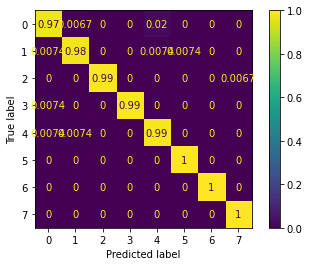

In [14]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
nfold = 10
kf = KFold(n_splits=nfold,shuffle=True,random_state=42)

yhat = cross_val_predict(logreg, Xs, y[1], cv=kf)
C = confusion_matrix(y[1],yhat,normalize='true')

# Plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=C)
disp.plot()

Re-run the logistic regression on the entire training data and get the weight coefficients.  This should be a 8 x 77 matrix.  Create a stem plot of the first row of this matrix to see the coefficients on each of the genes for the first class.

<StemContainer object of 3 artists>

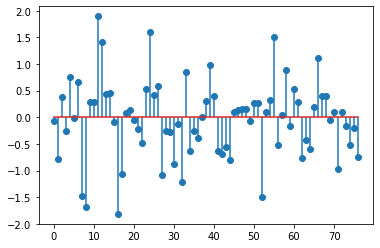

In [15]:

W= logreg.coef_

plt.stem(W[0,:])

## L1-Regularization

In most genetic problems, only a limited number of the tested genes are likely to influence any particular attribute.  Hence, we would expect that the weight coefficients in the logistic regression model should be sparse.  That is, they should be zero on any gene that plays no role in the particular attribute of interest.  Genetic analysis commonly imposes sparsity by adding an l1-penalty term.  Read the `sklearn` [documentation](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html) on the `LogisticRegression` class to see how to set the l1-penalty and the inverse regularization strength, `C`.

Using the model selection strategies from the [prostate cancer analysis demo](../unit03_model_sel/demo03_2_prostate.ipynb), use K-fold cross validation to select an appropriate inverse regularization strength.  
* Use 10-fold cross validation 
* You should select around 20 values of `C`.  It is up to you to find a good range.

In [16]:
from sklearn.model_selection import GridSearchCV

# Define the grid
npen = 20
C_lasso = np.logspace(-2,0,npen)

Now compute the mean and standard error on the error rate for each `C` and plot the results (Use `errorbar()` method).  Also determine and print the minimum test error rate and corresponding `C` value. 

The minimum test error rate =   8.3333e-03, SE=  2.9117e-03
The C value corresponding to minimum error =   1.0000e+00


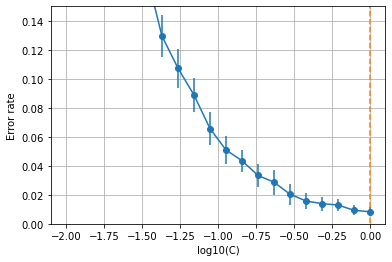

In [17]:
# TODO
# Create the lasso object
lasso = linear_model.LogisticRegression(penalty='l1', solver='liblinear', warm_start=True)

# Run cross-validation
parameters = {'C':C_lasso}
clf = GridSearchCV(lasso, parameters, cv=kf, scoring='accuracy')
clf.fit(Xs,y[1])

# Average test results across folds
err_mean = 1-clf.cv_results_['mean_test_score'] # error-rate = 1-accuracy
err_se = clf.cv_results_['std_test_score']/np.sqrt(nfold-1)
imin = np.argmin(err_mean)
C_min = C_lasso[imin]
plt.errorbar(np.log10(C_lasso), err_mean, marker='o',yerr=err_se)
xmin, xmax, ymin, ymax = plt.axis()
plt.plot(np.log10([C_min,C_min]),[ymin,ymax],'--')
plt.ylim([0,0.15])
plt.grid()
plt.xlabel('log10(C)')
plt.ylabel('Error rate')

print("The minimum test error rate = %12.4e, SE=%12.4e" % (err_mean[imin], err_se[imin]))
print("The C value corresponding to minimum error = %12.4e" % C_min)

We see that the minimum error rate is significantly below the classifier that did not use the l1-penalty.  Use the one-standard error rule to determine the optimal `C` and the corresponding test error rate. 

One-standard-error-rule C=  7.8476e-01
The test error rate =   9.2593e-03, SE=  3.3810e-03
Accuracy =  0.9907, SE=0.0034


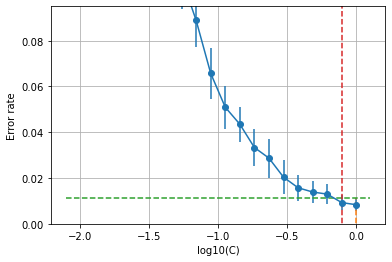

In [18]:
# TODO
# C_opt = 
# One-standard-error rule
err_tgt = err_mean[imin] + err_se[imin]
iose = np.where(err_mean < err_tgt)[0][0]
C_ose = C_lasso[iose]

# Plot error statistics versus C
plt.errorbar(np.log10(C_lasso), err_mean, marker='o',yerr=err_se)
xmin, xmax, ymin, ymax = plt.axis()
plt.plot(np.log10([C_min,C_min]),[ymin,err_tgt],'--')
plt.plot([xmin,xmax],[err_tgt,err_tgt],'--')
plt.plot(np.log10([C_ose,C_ose]),[ymin,ymax],'--')
plt.ylim([0,0.095])
plt.grid()
plt.xlabel('log10(C)')
plt.ylabel('Error rate')

print("One-standard-error-rule C=%12.4e" % C_ose)
print("The test error rate = %12.4e, SE=%12.4e" % (err_mean[iose], err_se[iose]))
print('Accuracy =  {0:.4f}, SE={1:.4f}'.format(1-err_mean[iose], err_se[iose]))

For the optimal `C`, fit the model on the entire training data with l1 regularization. Find the resulting weight matrix, `W_l1`.  Plot the first row of this weight matrix and compare it to the first row of the weight matrix without the regularization.  You should see that, with l1-regularization, the weight matrix is much more sparse and hence the roles of particular genes are more clearly visible. Also compare the accuracy for the training data using optimal `C` with the previous results not using LASSO regularization. Do you expect the accuracy to improve?

<Figure size 1008x288 with 0 Axes>

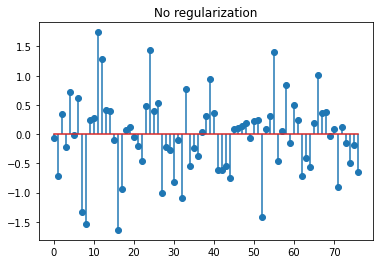

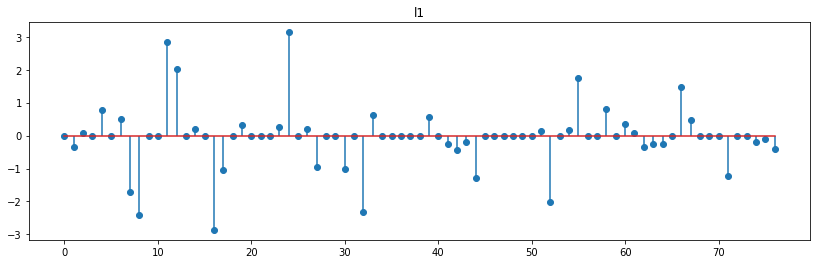

<Figure size 1008x288 with 0 Axes>

In [19]:
# Re-fit LASSO on entire training data
lasso = linear_model.LogisticRegression(C=C_ose,solver='liblinear')
lasso.fit(Xs,y[1])
W= lasso.coef_
plt.stem(W[0,:])
plt.title('No regularization')
plt.figure(figsize=(14,4))

lasso = linear_model.LogisticRegression(penalty='l1',C=C_ose,solver='liblinear')
lasso.fit(Xs,y[1])
W= lasso.coef_
plt.stem(W[0,:])
plt.title('l1')
plt.figure(figsize=(14,4))




In [20]:
yhat = lasso.predict(Xs)
acc = np.mean(yhat == y[1])
print("Accuracy on training data = %f" % acc)
print("old data data = %f" % 0.999074)

Accuracy on training data = 0.998148
old data data = 0.999074
